In [6]:
%matplotlib inline
from scipy.optimize import basinhopping
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy, pandas

In [7]:
data_0 = pandas.read_csv('../data/hits.csv', index_col=0)

data_1 = data_0.copy()
data_1['Wy1'] = data_0['Wy1'].values + data_0.dist2Wire.values
data_1['Wy2'] = data_0['Wy2'].values + data_0.dist2Wire.values
data_2 = data_0.copy()
data_2['Wy1'] = data_0['Wy1'].values - data_0.dist2Wire.values
data_2['Wy2'] = data_0['Wy2'].values - data_0.dist2Wire.values
data = pandas.concat([data_1, data_2], axis=0)

data['IsStereo'] = (data.ViewNb.values == 1) * 1. + (data.ViewNb.values == 2) * 1.

data.head()

,EventID,TrackID,PdgCode,DetectorID,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Px,...,dist2Wire,Wx1,Wx2,Wy1,Wy2,Wz,Wz1,Wz2,Label,IsStereo
79,2,2,-211,10002284,1,0,0,0,284,0.866347,...,0.042245,-250.000000,250.000000,0.910845,0.910845,2581.1500,2581.1500,2581.1500,0,0
111,2,2,-211,42012282,4,2,0,1,282,0.867240,...,0.478996,-248.589486,249.507863,27.516483,-16.061389,3542.3793,3542.3793,3542.3793,0,1
81,2,2,-211,11012288,1,1,0,1,288,0.866625,...,0.310706,-248.587499,249.509850,-26.749494,16.828378,2592.3793,2592.3793,2592.3793,0,1
43,2,3,-13,11012286,1,1,0,1,286,-0.239448,...,0.117904,-248.894287,249.203062,-23.435691,20.142180,2592.3793,2592.3793,2592.3793,1,1
88,2,2,-211,20012285,2,0,0,1,285,0.866401,...,0.437575,-250.000000,250.000000,0.426175,0.426175,2782.2500,2782.2500,2782.2500,0,0


In [8]:
event_id = 2
event = data[data.EventID==event_id]
hits = event[(event.StatNb <= 2)]

In [9]:

def R(params, hits):
    
    y1 = hits.Wy1.values
    y2 = hits.Wy2.values

    x1 = hits.Wx1.values
    x2 = hits.Wx2.values

    zz = hits.Wz.values

    A = (y1 - y2)
    B = (x2 - x1)
    C = (x1*y2 - x2*y1)
    
    a = params[0] + zz * params[1]
    b = params[2] + zz * params[3]
    
    r = (A*a + B*b + C) / (numpy.sqrt(A**2 + B**2))
    
    retina = numpy.exp(-(r/sigma)**2).sum()
    
    return -retina

def R_grad(params, hits):
    
    y1 = hits.Wy1.values
    y2 = hits.Wy2.values

    x1 = hits.Wx1.values
    x2 = hits.Wx2.values

    zz = hits.Wz.values

    A = (y1 - y2)
    B = (x2 - x1)
    C = (x1*y2 - x2*y1)
    
    a = params[0] + zz * params[1]
    b = params[2] + zz * params[3]
    
    r = (A*a + B*b + C) / (numpy.sqrt(A**2 + B**2))
    retina = numpy.exp(-(r/sigma)**2)
    
    
    
    g1 = - 2 * r / sigma**2 * retina * A / (numpy.sqrt(A**2 + B**2))
    g2 = - 2 * r / sigma**2 * retina * A * zz / (numpy.sqrt(A**2 + B**2))
    g3 = - 2 * r / sigma**2 * retina * B / (numpy.sqrt(A**2 + B**2))
    g4 = - 2 * r / sigma**2 * retina * B * zz / (numpy.sqrt(A**2 + B**2))
    
    return -numpy.array([g1.sum(), g2.sum(), g3.sum(), g4.sum()])

### Find tube crosses

In [10]:
xs = []
ys = []
zs = []

for i in range(len(hits)):
    
    for j in range(len(hits)):
        
        one = hits.iloc[i]
        two = hits.iloc[j]
        
        if one.StatNb != two.StatNb or numpy.abs(one.ViewNb - two.ViewNb) != 1 or j <= i:
            continue
            
        y1 = one.Wy1
        y2 = one.Wy2

        x1 = one.Wx1
        x2 = one.Wx2

        z12 = one.Wz
        
        k12 = (y2 - y1) / (x2 - x1)
        b12 = y1 - k12 * x1
        
        
        y3 = two.Wy1
        y4 = two.Wy2

        x3 = two.Wx1
        x4 = two.Wx2

        z34 = two.Wz
        
        k34 = (y4 - y3) / (x4 - x3)
        b34 = y3 - k34 * x3
        
        x = (b12 - b34) / (k34 - k12)
        y = k12 * x + b12
        z = 0.5 * (z12 + z34)
        
        if numpy.abs(x) <= 300:
        
            xs.append(x)
            ys.append(y)
            zs.append(z)

### Calculate the retina values for each pairs of the crosses.

In [34]:
%%time

rs = []
sigma = 1.
ps = []

for i in range(len(xs)):
    
    for j in range(len(xs)):
        
        if j <= i or zs[i] == zs[j] or numpy.random.rand() >= 0.01:
            continue
            
        x1 = xs[i]
        x2 = xs[j]
        
        y1 = ys[i]
        y2 = ys[j]
        
        z1 = zs[i]
        z2 = zs[j]
        
        k_y = (y2 - y1) / (z2 - z1)
        b_y = y1 - k_y * z1
        
        k_stereo = (x2 - x1) / (z2 - z1)
        b_stereo = x1 - k_stereo * z1
        
        params = [b_stereo, k_stereo, b_y, k_y]
        r = - R(params, hits)
        
        #res = minimize(R, params, method='BFGS', jac=R_grad, options={'gtol': 1e-6, 'disp': False})
        
        #r = - R(res.x)

        rs.append(r)
        #ps.append(res.x)
        ps.append(params)
        
rs = numpy.array(rs)
ps = numpy.array(ps)

CPU times: user 154 ms, sys: 4.11 ms, total: 158 ms
Wall time: 158 ms


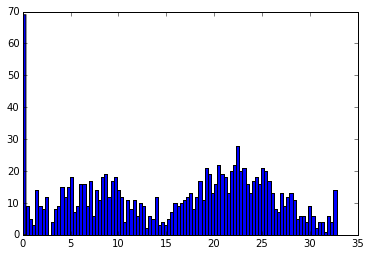

In [35]:
plt.hist(rs, bins=100)
plt.show()

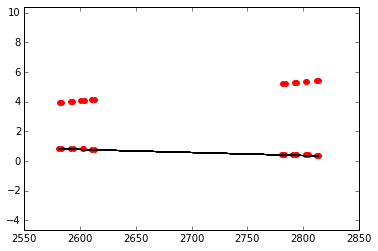

In [36]:
for p in ps[rs == rs.max()]:
    plt.plot(hits.Z.values, hits.Z.values * p[3] + p[2], color='0', alpha=1)
    
plt.scatter(hits.Z.values, hits.Y.values, color='r')
plt.ylim(hits.Y.values.min()-5., hits.Y.values.max()+5.)
plt.show()

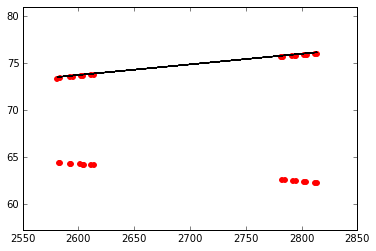

In [37]:
for p in ps[rs == rs.max()]:
    plt.plot(hits.Z.values, hits.Z.values * p[1] + p[0], color='0', alpha=1)
    
plt.scatter(hits.Z.values, hits.X.values, color='r')
plt.ylim(hits.X.values.min()-5., hits.X.values.max()+5.)
plt.show()

# With Optimization

In [46]:
%%time

rs = []
sigma = 1.
ps = []

for i in range(len(xs)):
    
    for j in range(len(xs)):
        
        if j <= i or zs[i] == zs[j] or numpy.random.rand() >= 0.01:
            continue
            
        x1 = xs[i]
        x2 = xs[j]
        
        y1 = ys[i]
        y2 = ys[j]
        
        z1 = zs[i]
        z2 = zs[j]
        
        k_y = (y2 - y1) / (z2 - z1)
        b_y = y1 - k_y * z1
        
        k_stereo = (x2 - x1) / (z2 - z1)
        b_stereo = x1 - k_stereo * z1
        
        params = [b_stereo, k_stereo, b_y, k_y]
        #r = - R(params, hits)
        
        res = minimize(R, params, args=(hits), method='BFGS', jac=R_grad, options={'gtol': 1e-6, 'disp': False})
        
        r = - R(res.x, hits)

        rs.append(r)
        ps.append(res.x)
        #ps.append(params)
        
rs = numpy.array(rs)
ps = numpy.array(ps)

CPU times: user 21.4 s, sys: 275 ms, total: 21.7 s
Wall time: 22.8 s


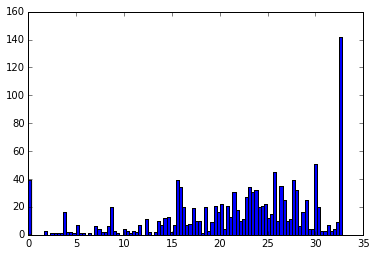

In [47]:
plt.hist(rs, bins=100)
plt.show()

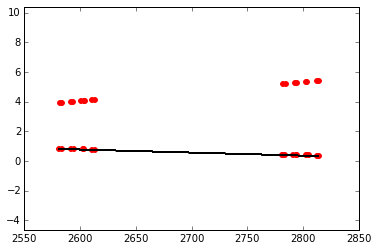

In [48]:
for p in ps[rs == rs.max()]:
    plt.plot(hits.Z.values, hits.Z.values * p[3] + p[2], color='0', alpha=1)
    
plt.scatter(hits.Z.values, hits.Y.values, color='r')
plt.ylim(hits.Y.values.min()-5., hits.Y.values.max()+5.)
plt.show()

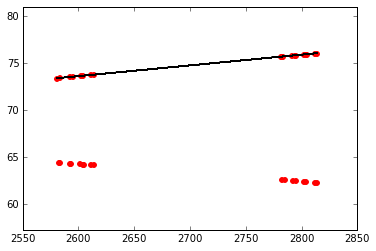

In [49]:
for p in ps[rs == rs.max()]:
    plt.plot(hits.Z.values, hits.Z.values * p[1] + p[0], color='0', alpha=1)
    
plt.scatter(hits.Z.values, hits.X.values, color='r')
plt.ylim(hits.X.values.min()-5., hits.X.values.max()+5.)
plt.show()